In [1]:
%pip install --upgrade --quiet tf-nightly-2.0-preview #tf-nightly

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190629


In [2]:
import tensorflow as tf
import pandas as pd
import datetime
print(tf.__version__)
import shutil
import os

# serving inputs to model
inputs = {
    'a' : tf.keras.layers.Input(name='a', shape=(), dtype='string')
}

DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
def get_dayofweek(s):
    # Python 3.5 doesn't handle timezones of the form 00:00, only 0000
    s1 = s.numpy().decode('utf-8') # get Python string
    ts = datetime.datetime.strptime(s1.replace(':',''), "%Y-%m-%d %H%M%S%z")
    return DAYS[ts.weekday()]

def dayofweek(ts_in):
    return tf.map_fn(
        lambda s: tf.py_function(get_dayofweek, inp=[s], Tout=tf.string),
        ts_in
    )

# inputs to model with which model is trained
transformed = inputs.copy()
transformed['d'] = tf.keras.layers.Lambda(lambda x: dayofweek(x), name='dayofweek_pyfun')(inputs['a'])
transformed['d'] = tf.keras.layers.Reshape((), name='dayofweek')(transformed['d'])

transformed['h'] = tf.keras.layers.Lambda(
        lambda x: tf.strings.to_number(tf.strings.substr(x, 11, 2), out_type=tf.dtypes.int32),
        name='hourofday'
    )(inputs['a'])

# feature columns based on training inputs
fc = {
    'd' : tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list('d', vocabulary_list = DAYS)),
    'h' : tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_identity('h', num_buckets = 24)),
}

# b/135479527
#dh = tf.feature_column.crossed_column(['d', 'h'], 2 )
#fc['dh'] = tf.feature_column.embedding_column(dh, 2)
    

# model architecture
fare_thresh = lambda x: 60 * tf.keras.activations.relu(x)
ds = tf.keras.layers.DenseFeatures(fc.values())(transformed)
output = tf.keras.layers.Dense(1, name='pred')(ds)
#output = tf.keras.layers.Dense(1, activation=fare_thresh, name='fare')(ds) # b/136476088
model = tf.keras.models.Model(inputs=inputs, outputs=output)



def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])

df = pd.DataFrame.from_dict({
    'a': ['2010-02-08 09:17:00+00:00', '2010-02-09 09:17:00+00:00', '2010-02-07 09:17:00+00:00'],
})
y =  [3.0, 2.0, 2.0]


shutil.rmtree('04_keras/checkpoints/', ignore_errors=True)
checkpoint_path = "04_keras/checkpoints/nightly.cpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit([df['a']], y, steps_per_epoch=1, callbacks=[cp_callback])
model.evaluate([df['a']], y)

model.predict({
    'a': tf.convert_to_tensor(['2010-02-08 09:17:00+00:00']),
})

W0701 17:39:20.871020 140075871741696 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4281: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0701 17:39:20.872119 140075871741696 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4336: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0701 17:39:20.918486 140075871741696 deprecation.py:323] From /home/jupyter/.local/lib/python3

2.0.0-dev20190629


W0701 17:39:20.997879 140075871741696 training_utils.py:1144] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.
W0701 17:39:21.082270 140075871741696 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 1 samples

Epoch 00001: saving model to 04_keras/checkpoints/nightly.cpt
3/3 [==============================] - 0s 29ms/sample - loss: 6.2406 - rmse: 2.4981 - mse: 6.2406


array([[-0.35985315]], dtype=float32)

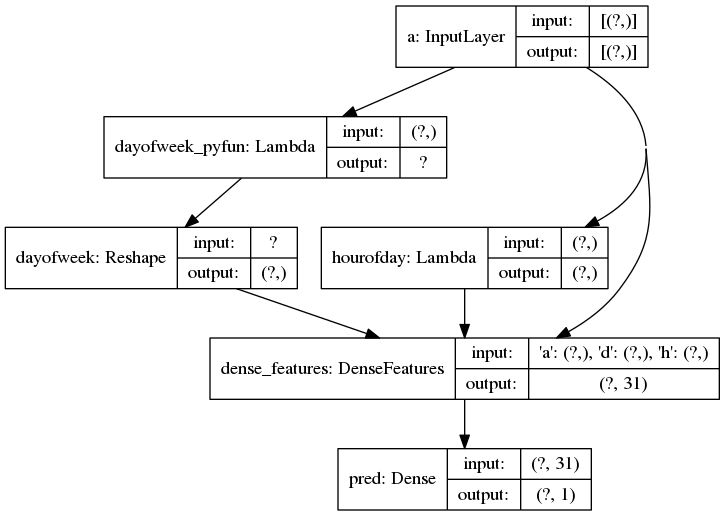

In [3]:
tf.keras.utils.plot_model(model, 'repro_model.png', show_shapes=True)

In [4]:
# export as SavedModel
shutil.rmtree('04_keras/export/savedmodel', ignore_errors=True)
tf.keras.experimental.export_saved_model(model, '04_keras/export/savedmodel')

W0701 17:39:22.248620 140075871741696 deprecation.py:323] From <ipython-input-4-f42e5ded74e3>:3: export_saved_model (from tensorflow.python.keras.saving.saved_model_experimental) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.
W0701 17:39:22.407885 140075871741696 deprecation.py:506] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1624: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0701 17:39:22.812583 140075871741696 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.sav

In [5]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir 04_keras/export/savedmodel

The given SavedModel SignatureDef contains the following input(s):
  inputs['a'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: a:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['pred'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: pred/BiasAdd:0
Method name is: tensorflow/serving/predict


In [6]:
!find 04_keras/export/savedmodel

04_keras/export/savedmodel
04_keras/export/savedmodel/assets
04_keras/export/savedmodel/assets/saved_model.json
04_keras/export/savedmodel/variables
04_keras/export/savedmodel/variables/variables.data-00001-of-00002
04_keras/export/savedmodel/variables/variables.index
04_keras/export/savedmodel/variables/variables.data-00000-of-00001
04_keras/export/savedmodel/variables/variables.data-00000-of-00002
04_keras/export/savedmodel/variables/checkpoint
04_keras/export/savedmodel/saved_model.pb


In [7]:
# restore from SavedModel
loaded_model = tf.keras.experimental.load_from_saved_model('04_keras/export/savedmodel')
loaded_model.predict({
    'a': tf.convert_to_tensor(['2010-02-08 09:17:00+00:00']),
})

W0701 17:39:26.216993 140075871741696 deprecation.py:323] From <ipython-input-7-81e377f898f9>:2: load_from_saved_model (from tensorflow.python.keras.saving.saved_model_experimental) is deprecated and will be removed in a future version.
Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.
W0701 17:39:26.275084 140075871741696 util.py:144] Unresolved object in checkpoint: (root).optimizer
W0701 17:39:26.276020 140075871741696 util.py:144] Unresolved object in checkpoint: (root).optimizer.iter
W0701 17:39:26.277042 140075871741696 util.py:144] Unresolved object in checkpoint: (root).optimizer.beta_1
W0701 17:39:26.277798 140075871741696 util.py:144] Unresolved object in checkpoint: (root).optimizer.beta_2
W0701 17:39:26.278487 140075871741696 util.py:144] Unresolved object in checkpoint: (root).optimizer.decay
W0701 17:39:26.279385 140075871741696 util.py:144] Unresolved object in checkpoint: (root).opti

array([[-0.35985315]], dtype=float32)

In [8]:
%%writefile repro.json
{"a": "2010-02-08 09:17:00+00:00"}

Overwriting repro.json


In [10]:
!python3 --version

Python 3.5.3


In [59]:
%%bash
MODEL_NAME=repro
VERSION_NAME=v1
if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    # create model
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=us-central1 $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 10
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --framework=tensorflow --origin=04_keras/export/savedmodel --staging-bucket=gs://cloud-training-demos-ml

repro already exists
Creating repro:v1


In [50]:
!gcloud ai-platform versions list --model repro --format='value(name)'

v1


In [57]:
!gcloud ai-platform predict --model=repro --version=v1 --json-instances=repro.json

ERROR: (gcloud.ai-platform.predict) HTTP request failed. Response: {
  "error": {
    "code": 404,
    "message": "Field: name Error: Online prediction is unavailable for this version. Please verify that CreateVersion has completed successfully.",
    "status": "NOT_FOUND",
    "details": [
      {
        "@type": "type.googleapis.com/google.rpc.BadRequest",
        "fieldViolations": [
          {
            "field": "name",
            "description": "Online prediction is unavailable for this version. Please verify that CreateVersion has completed successfully."
          }
        ]
      }
    ]
  }
}

